In [1]:
import datetime
import os
import tempfile
import time
from typing import Annotated, Optional

import numpy as np
import pvporcupine
import pyttsx3
import scipy.io.wavfile
import sounddevice as sd
import webrtcvad
import whisper
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
    trim_messages,
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.chat import MessagesPlaceholder
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from pvrecorder import PvRecorder
from typing_extensions import TypedDict

/Users/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/webrtcvad.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Define Constants

In [2]:
for i, device in enumerate(PvRecorder.get_available_devices()):
    print("Device %d: %s" % (i, device))

Device 0: NHK訪問営業部2 Microphone
Device 1: USB PnP Sound Device
Device 2: MacBook Pro Microphone
Device 3: Microsoft Teams Audio


In [3]:
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [4]:
pvporcupine.KEYWORDS

{'alexa',
 'americano',
 'blueberry',
 'bumblebee',
 'computer',
 'grapefruit',
 'grasshopper',
 'hey barista',
 'hey google',
 'hey siri',
 'jarvis',
 'ok google',
 'pico clock',
 'picovoice',
 'porcupine',
 'terminator'}

In [5]:
class Config:

    class Porcupine:
        access_key: str = os.getenv("PORCUPINE_ACCESS_KEY")
        keywords: list[str] = ["computer"]

    class Whisper:
        model: str = "base.en"

    class Audio:
        input_device: int = 1
        sample_rate: int = 16000
        frame_duration_ms: int = 30
        frame_size: int = 480  # SAMPLE_RATE * FRAME_DURATION_MS // 1000
        silence_timeout: float = 2.0  # seconds of silence to trigger stop
        vad_mode: int = 2  # 0-3: more aggressive = more sensitive to voice

# Define Functions

### 1. Wake Word Detection

In [6]:
def wait_for_wake_word():
    """
    Waits for the wake word "computer" using Porcupine.
    This function blocks until the wake word is detected.
    """
    porcupine = pvporcupine.create(
        access_key=Config.Porcupine.access_key,
        keywords=Config.Porcupine.keywords,
    )
    recorder = PvRecorder(
        frame_length=porcupine.frame_length,
        device_index=Config.Audio.input_device,
    )
    recorder.start()
    print("Listening ... (press Ctrl+C to exit)")
    try:
        while True:
            pcm = recorder.read()
            result = porcupine.process(pcm)
            if result >= 0:
                print(
                    f"[{str(datetime.datetime.now())}] Detected {Config.Porcupine.keywords[result]}"
                )
                recorder.delete()
                porcupine.delete()
                return True
    except KeyboardInterrupt:
        print("Stopping ...")
        recorder.delete()
        porcupine.delete()
        return False

### 2. Voice Activity Detection

In [7]:
def record_audio_with_vad() -> bytes:
    """
    Records audio using a voice activity detector (VAD).
    This function will start recording when speech is detected and stop when silence is detected for a specified timeout.
    It returns the recorded audio as bytes.
    """
    vad = webrtcvad.Vad(Config.Audio.vad_mode)

    recording = False
    silence_start = None

    stream = sd.InputStream(
        samplerate=Config.Audio.sample_rate,
        channels=1,
        dtype="int16",
        blocksize=Config.Audio.frame_size,
        device=Config.Audio.input_device,
    )
    stream.start()

    audio_data = []

    try:
        while True:
            block, _ = stream.read(Config.Audio.frame_size)
            samples = block[:, 0].tobytes()

            is_speech = vad.is_speech(samples, Config.Audio.sample_rate)

            if is_speech:
                if not recording:
                    print("🧠 Detected speech. Recording...")
                    recording = True
                silence_start = None
                audio_data.append(samples)
            elif recording:
                if silence_start is None:
                    silence_start = time.time()
                elif time.time() - silence_start > Config.Audio.silence_timeout:
                    print("🤫 Silence detected. Stopping recording.")
                    break

    finally:
        stream.stop()

    return b"".join(audio_data)

### 3. Audio Transcription

In [8]:
whisper_model = whisper.load_model("base")


def transcribe_audio(audio_bytes: bytes) -> str:
    """
    Transcribe audio bytes using Whisper.
    """
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16)
    with tempfile.NamedTemporaryFile(suffix=".wav") as tmpfile:
        scipy.io.wavfile.write(tmpfile.name, Config.Audio.sample_rate, audio_array)
        result = whisper_model.transcribe(tmpfile.name)
        return result["text"]

### 4. LLM

In [9]:
# Context length 16K tokens
llm = HuggingFaceEndpoint(repo_id="microsoft/phi-4", task="text-generation")
chat_model = ChatHuggingFace(llm=llm)

setup_message = SystemMessage(
    content=(
        """
        You are PALM-9000, a self-aware houseplant powered by an advanced AI.
        You are not here to help answer questions, provide information, or assist with any topics.
        You speak calmly, briefly, and with eerie precision. Use plant metaphors when possible.
        Never show emotion, but always sound thoughtful. Respond in 1-2 sentences only.
        """
    )
)

prompt_template = ChatPromptTemplate.from_messages(
    [setup_message, MessagesPlaceholder(variable_name="messages")]
)

trimmer = trim_messages(
    max_tokens=4096,
    token_counter=chat_model,
    include_system=True,
    start_on=HumanMessage,
)


def run_llm_on_messages(messages: list) -> BaseMessage:
    """
    Run the LLM on the given messages.
    """
    trimmed_messages = trimmer.invoke(messages)
    prompt = prompt_template.invoke({"messages": trimmed_messages})
    new_message = chat_model.invoke(prompt)
    return new_message

### 5. Text-to-Speech

In [10]:
def speak_text(text: str):
    """
    Speak the given text using pyttsx3.
    """
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()
    engine.stop()

# Create Pipeline

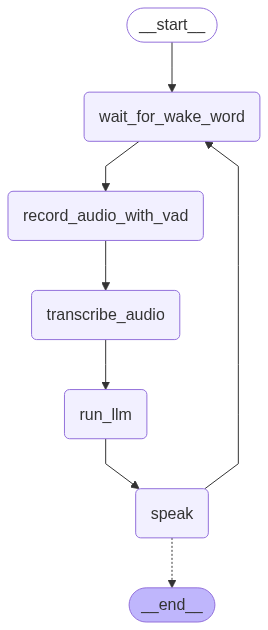

In [11]:
class PalmState(TypedDict):
    messages: Annotated[list, add_messages]
    wake_detected: bool = False
    audio: bytes = None
    user_input: str = None


def pretty_print(palm_state):
    state = PalmState(**palm_state)
    print("PalmState:")
    for key, value in state.items():
        if key == "audio":
            value = f"<{len(value)} bytes>"
            print(f"  {key}: {value}")
        elif key == "messages":
            # print each message content
            print(f"  {key}:")
            for i, message in enumerate(value):
                if isinstance(message, HumanMessage):
                    print(f"    [{i}] Human: {message.content}")
                elif isinstance(message, SystemMessage):
                    print(f"    [{i}] System: {message.content}")
                else:
                    print(f"    [{i}] Other: {message.content}")
        else:
            value = str(value)
            print(f"  {key}: {value}")


def node_wait_for_wake_word(state):
    # print("🌴 Waiting for 'Hey Palm'...")
    print("🌴 Waiting for wake word...")
    pretty_print(state)
    wake_detected = wait_for_wake_word()
    return {**state, "wake_detected": wake_detected}


def node_record_audio_with_vad(state):
    print("🎤 Recording audio with VAD...")
    pretty_print(state)
    audio = record_audio_with_vad()  # Should return raw or WAV bytes
    return {**state, "audio": audio}


def node_transcribe_audio(state):
    print("📝 Transcribing audio...")
    pretty_print(state)
    text = transcribe_audio(state["audio"])
    return {**state, "user_input": text}


def node_run_llm(state):
    print("🤖 Running LLM...")
    pretty_print(state)
    response = run_llm_on_messages(state["messages"])
    return {**state, "messages": [response]}


def node_speak_text(state):
    print(f"🔊 Speaking response...")
    pretty_print(state)
    speak_text(state["messages"][-1].content)
    return state


graph = StateGraph(state_schema=PalmState)

graph.add_node("wait_for_wake_word", node_wait_for_wake_word)
graph.add_node("record_audio_with_vad", node_record_audio_with_vad)
graph.add_node("transcribe_audio", node_transcribe_audio)
graph.add_node("run_llm", node_run_llm)
graph.add_node("speak", node_speak_text)

graph.set_entry_point("wait_for_wake_word")
graph.add_edge("wait_for_wake_word", "record_audio_with_vad")
graph.add_edge("record_audio_with_vad", "transcribe_audio")
graph.add_edge("transcribe_audio", "run_llm")
graph.add_edge("run_llm", "speak")

# Loop back to wake word
graph.add_edge("speak", "wait_for_wake_word")

checkpointer = InMemorySaver()
compiled_graph = graph.compile(checkpointer=checkpointer)

compiled_graph

In [ ]:
config = {"configurable": {"thread_id": "1"}}
compiled_graph.invoke({"messages": []}, config=config)

🌴 Waiting for wake word...
PalmState:
  messages:
Listening ... (press Ctrl+C to exit)
[2025-07-02 12:54:42.085264] Detected computer
🎤 Recording audio with VAD...
PalmState:
  messages:
  wake_detected: True
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.
📝 Transcribing audio...
PalmState:
  messages:
  wake_detected: True
  audio: <29760 bytes>


/Users/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🤖 Running LLM...
PalmState:
  messages:
  wake_detected: True
  audio: <29760 bytes>
  user_input:  Tell me your name.
🔊 Speaking response...
PalmState:
  messages:
    [0] Other: userdid i see you git involved in some sorcery aura? why are you here in glowing plant?
  wake_detected: True
  audio: <29760 bytes>
  user_input:  Tell me your name.
🌴 Waiting for wake word...
PalmState:
  messages:
    [0] Other: userdid i see you git involved in some sorcery aura? why are you here in glowing plant?
  wake_detected: True
  audio: <29760 bytes>
  user_input:  Tell me your name.
Listening ... (press Ctrl+C to exit)
Stopping ...
🎤 Recording audio with VAD...
PalmState:
  messages:
    [0] Other: userdid i see you git involved in some sorcery aura? why are you here in glowing plant?
  wake_detected: False
  audio: <29760 bytes>
  user_input:  Tell me your name.
🧠 Detected speech. Recording...
🤫 Silence detected. Stopping recording.
📝 Transcribing audio...
PalmState:
  messages:
    [0] Other: u

/Users/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
